# <center> <font color=blue> Customer Churn Prediction in Telecom industry </font> </center>

## Introduction:

Churn is defined as non completion of a business critical event by the customer with in a specificed interval of time. Depending on the nature of business churn can be classified as one of the below actions

- who purchased before and hasn't completed atleast one purchase with in a specificed interval
- when customer hasn't used the product with in a specificed interval
- who cancelled subscription of service which they were continuously paying for previously

Customers churn either voluntarily or involuntarily. Involuntary churn happens when the customer choses not to continue using the product for factors beyond the company's control like relocation, death. Voluntary churn is defined as when customer chooses to switch to a different product because of various factors. Companies are intersted in knowing this segment of customers so that they can take corrective actions and direct their marketing, customer relation teams to reduce this voluntary churn. 

In this fast moving digital world, retaining a customer is much cheaper than trying to win back a churn customer. Hence data science methods to identify and predict the cluster of customers who have a higher probablity to churn is a very valuable resource that companies engage to take the right business decisions.
    

## Problem Statement:

In this analysis, I will be using a sample data set shared by IBM on telecom customer data to analyze and predict the customers who are most likely to churn. Churn is defined as the customer who left with in the last six months. 

By analyzing the customer behaviour to predict churn, the telecom company can develop customer retention programs to retain these customers thus preventing churn.

## About the Data set: 

Data set has been downloaded from 

- https://www.kaggle.com/blastchar/telco-customer-churn

The data set includes information about:

- Customers who left within the last month – the column is called Churn
- Services that each customer has signed up for – phone, multiple lines, internet, online security, online backup, device protection, tech support, and streaming TV and movies
- Customer account information – how long they’ve been a customer, contract, payment method, paperless billing, monthly charges, and total charges
- Demographic info about customers – gender, age range, and if they have partners and dependents

## Importing all the necessary libraries

In [127]:
import numpy as np 
import pandas as pd

# For data manipulations using SQL format
from pandasql import *

# For visualization
import seaborn as sns
import ipython_genutils
import matplotlib.pyplot as plt
import plotly.plotly as py
import plotly.tools as tls
from textwrap import wrap 

# For Statistical Analysis(Logistic)
from sklearn import metrics
from sklearn.cross_validation import train_test_split
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix

from imblearn.over_sampling import SMOTE

import statsmodels.api as sm
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tools.sm_exceptions import ValueWarning, \
    HessianInversionWarning


## Data overview

- I imported the dataset into a pandas data frame
- This raw data set has 7043 rows and 21 columns

In [168]:
cust_data = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')

cust_data.shape

(7043, 21)

In [169]:
# Printing out the top 5 rows have a quick sneak peak into the imported dataset

cust_data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


## Data cleaning and Manipulations

Before building a model, we need to use a clean data set with no missing values or incompatible column types. In this step, I
- removed rows with missing values
- removed duplicate rows
- Indentified and converted the column data types to their right data type which represents the nature of the metric

In [170]:
cust_data = cust_data.dropna(how="all")  # remove samples with all missing values

In [171]:
cust_data = cust_data[~cust_data.duplicated()] # remove duplicates
cust_data.shape

(7043, 21)

Removing the missing rows where the total charges are not available are reducing the data by 11 rows

In [175]:
total_charges_filter = cust_data.TotalCharges == " " # remove the missing values in this columns
cust_data = cust_data[~total_charges_filter]
cust_data.shape

(7032, 21)

In [180]:
cust_data.dtypes

customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

Total CHarges should be numeric value as it is dollor amount

In [39]:
cust_data.TotalCharges = pd.to_numeric(cust_data.TotalCharges)

In [40]:
cust_data.describe()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges
count,7032.000000,7032.000000,7032.000000,7032.000000
mean,0.162400,32.421786,64.798208,2283.300441
std,0.368844,24.545260,30.085974,2266.771362
min,0.000000,1.000000,18.250000,18.800000
25%,0.000000,9.000000,35.587500,401.450000
50%,0.000000,29.000000,70.350000,1397.475000
75%,0.000000,55.000000,89.862500,3794.737500
max,1.000000,72.000000,118.750000,8684.800000


### Identifying the unique values for each column Type

Identifying the unique values for each column Type helps us form the basis for explororatory data analysis. While df.describe gives the distribution of numeric values, getting the distinct column values for non numeric columns helps in constructing the relation between that column and our predictor variable - Churn 

In [41]:
for item in cust_data.columns:
    print(item)
    print (cust_data[item].unique())

customerID
['7590-VHVEG' '5575-GNVDE' '3668-QPYBK' ... '4801-JZAZL' '8361-LTMKD'
 '3186-AJIEK']
gender
['Female' 'Male']
SeniorCitizen
[0 1]
Partner
['Yes' 'No']
Dependents
['No' 'Yes']
tenure
[ 1 34  2 45  8 22 10 28 62 13 16 58 49 25 69 52 71 21 12 30 47 72 17 27
  5 46 11 70 63 43 15 60 18 66  9  3 31 50 64 56  7 42 35 48 29 65 38 68
 32 55 37 36 41  6  4 33 67 23 57 61 14 20 53 40 59 24 44 19 54 51 26 39]
PhoneService
['No' 'Yes']
MultipleLines
['No phone service' 'No' 'Yes']
InternetService
['DSL' 'Fiber optic' 'No']
OnlineSecurity
['No' 'Yes' 'No internet service']
OnlineBackup
['Yes' 'No' 'No internet service']
DeviceProtection
['No' 'Yes' 'No internet service']
TechSupport
['No' 'Yes' 'No internet service']
StreamingTV
['No' 'Yes' 'No internet service']
StreamingMovies
['No' 'Yes' 'No internet service']
Contract
['Month-to-month' 'One year' 'Two year']
PaperlessBilling
['Yes' 'No']
PaymentMethod
['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (autom

#### Some of the column are categorical whick takes Yes & No as their distinct values. 
We need to convert them to 1's and 0's to make it usable for building a regression model

In [42]:
columns_to_convert = ['Partner', 
                      'Dependents', 
                      'PhoneService', 
                      'PaperlessBilling', 
                      'Churn']

for item in columns_to_convert:
    cust_data[item].replace(to_replace='Yes', value=1, inplace=True)
    cust_data[item].replace(to_replace='No',  value=0, inplace=True)

cust_data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,1,0,1,0,No phone service,DSL,No,...,No,No,No,No,Month-to-month,1,Electronic check,29.85,29.85,0
1,5575-GNVDE,Male,0,0,0,34,1,No,DSL,Yes,...,Yes,No,No,No,One year,0,Mailed check,56.95,1889.50,0
2,3668-QPYBK,Male,0,0,0,2,1,No,DSL,Yes,...,No,No,No,No,Month-to-month,1,Mailed check,53.85,108.15,1
3,7795-CFOCW,Male,0,0,0,45,0,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,0,Bank transfer (automatic),42.30,1840.75,0
4,9237-HQITU,Female,0,0,0,2,1,No,Fiber optic,No,...,No,No,No,No,Month-to-month,1,Electronic check,70.70,151.65,1


In [43]:
cust_data.dtypes

customerID           object
gender               object
SeniorCitizen         int64
Partner               int64
Dependents            int64
tenure                int64
PhoneService          int64
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling      int64
PaymentMethod        object
MonthlyCharges      float64
TotalCharges        float64
Churn                 int64
dtype: object

## Exploratory data Analysis

#### Exploratory data analysis (EDA) is an approach to analyzing data sets to summarize their main characteristics, often with visual methods.

#### Gender Distribution in Total dataset: 

The data set has almost equal proportions of Male and female customers

,gender,cnt
0,Female,3483
1,Male,3549


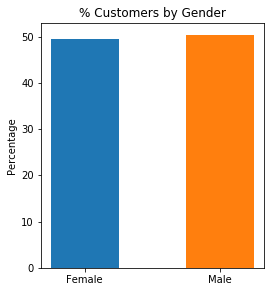

In [44]:
gender = """
    select gender, count(*) as cnt from cust_data group by gender
"""

gender_df = sqldf(gender, locals())


objects = gender_df["gender"]
y_pos = np.arange(len(objects))
performance = gender_df["cnt"]*100/(3488+3555)
color = ['C0', 'C1']
 
plt.figure(figsize=(4,4.5))
plt.bar(y_pos, performance, align='center', alpha=1, width=0.5, color = color)
plt.xticks(y_pos, objects)
plt.ylabel('Percentage')
plt.title('% Customers by Gender')
    
while True:
    display(gender_df)
    break 
    
plt.show()

#### Senior Citizen distribution in Total dataset: 
- Non senior citizens form the majority
- ~84% of the overall customers are non senior citizens

,SeniorCitizen,cnt
0,0,5890
1,1,1142


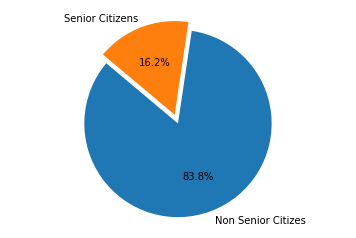

In [45]:
SC = """
    select SeniorCitizen, count(*) as cnt from cust_data group by SeniorCitizen
"""

SC_df = sqldf(SC, locals())

labels = ['Non Senior Citizes','Senior Citizens']
sizes = SC_df['cnt']
colors = ['C0','C1']
explode = (0.1, 0)  # explode 1st slice
 
# Plot
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
autopct='%1.1f%%', startangle=140)

while True:
    display(SC_df)
    break
 
plt.axis('equal')
plt.show()

### Count of Customers by Tenure
- 1 month and 72 months are the top segments by tenure
- Between the maximum tenure of 6 years, more half of the customers have been <=3 years with the company

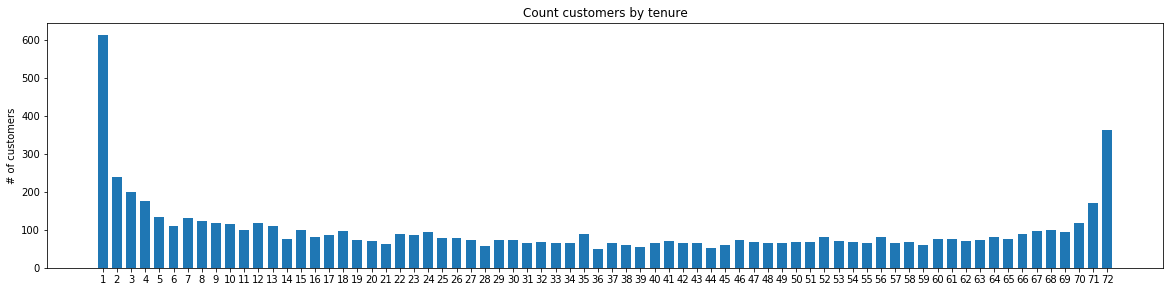

In [46]:
Active_time = """
    select tenure, count(*) as cnt from cust_data group by tenure
"""

AT_df = sqldf(Active_time, locals())

objects = AT_df["tenure"]
y_pos = np.arange(len(objects))
performance = AT_df["cnt"]
#color = ['C0', 'C1']
 
plt.figure(figsize=(20,4.5))
plt.bar(y_pos, performance, align='center', alpha=1, width=0.7)
plt.xticks(y_pos, objects)
plt.ylabel('# of customers')
plt.title('Count customers by tenure')
    
plt.show()

### Customers by Contract Type
- Majority 50% of the customers are month to month contract type

,Contract,cnt
0,Month-to-month,3875
1,One year,1472
2,Two year,1685


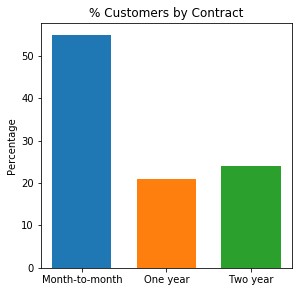

In [47]:
Contract_type = """
    select contract, count(*) as cnt from cust_data group by contract
"""

CT_df = sqldf(Contract_type, locals())

objects = CT_df["Contract"]
y_pos = np.arange(len(objects))
performance = CT_df["cnt"]*100/(3875+1473+1695)
color = ['C0', 'C1', 'C2']
 
plt.figure(figsize=(4.5,4.5))
plt.bar(y_pos, performance, align='center', alpha=1, width=0.7, color = color)
plt.xticks(y_pos, objects)
plt.ylabel('Percentage')
plt.title('% Customers by Contract')
    
while True:
    display(CT_df)
    break
    
plt.show()

In [48]:
Contract_type_Tenure = """
    select contract, tenure , count(*) as cnt from cust_data group by contract, tenure
"""

CTT_df = sqldf(Contract_type_Tenure, locals())

print(CTT_df.head())

         Contract  tenure  cnt
0  Month-to-month       1  604
1  Month-to-month       2  230
2  Month-to-month       3  191
3  Month-to-month       4  165
4  Month-to-month       5  128


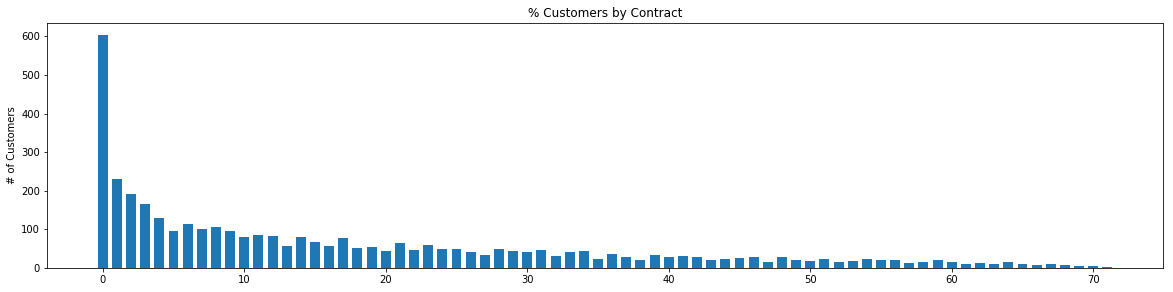

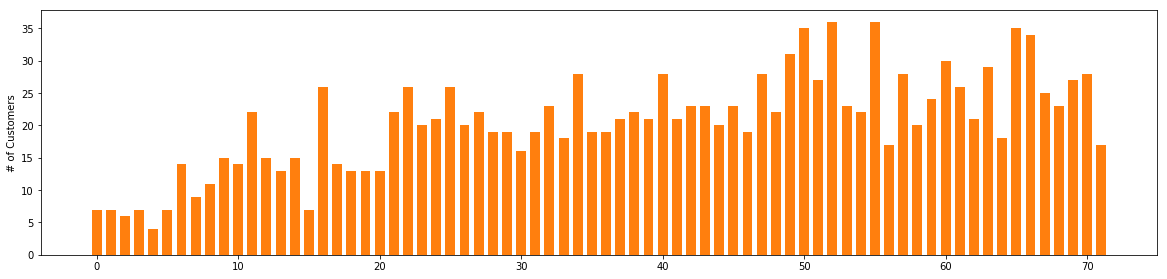

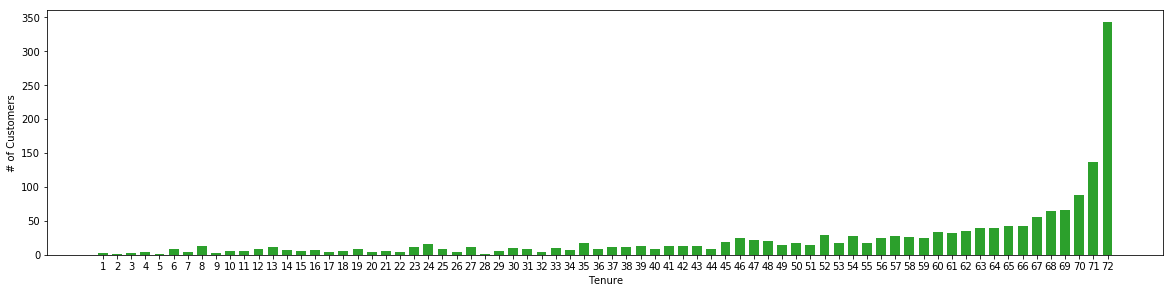

In [49]:
objects = CTT_df[CTT_df['Contract'] == 'Month-to-month']['tenure']
y_pos = np.arange(len(objects))
performance = CTT_df[CTT_df['Contract'] == 'Month-to-month']["cnt"]
color = ['C0']
 
plt.figure(figsize=(20,4.5))
plt.bar(y_pos, performance, align='center', alpha=1, width=0.7, color = color)
#plt.xticks(y_pos, objects)
plt.ylabel('# of Customers')
plt.title('% Customers by Contract')
plt.show()

objects = CTT_df[CTT_df['Contract'] == 'One year']['tenure']
y_pos = np.arange(len(objects))
performance = CTT_df[CTT_df['Contract'] == 'One year']["cnt"]
color = ['C1']

plt.figure(figsize=(20,4.5))
plt.bar(y_pos, performance, align='center', alpha=1, width=0.7, color = color)
#plt.xticks(y_pos, objects)
plt.ylabel('# of Customers')
#plt.title('% Customers by Contract')
plt.show()

objects = CTT_df[CTT_df['Contract'] == 'Two year']['tenure']
y_pos = np.arange(len(objects))
performance = CTT_df[CTT_df['Contract'] == 'Two year']["cnt"]
color = ['C2']

plt.figure(figsize=(20,4.5))
plt.bar(y_pos, performance, align='center', alpha=1, width=0.7, color = color)
plt.xticks(y_pos, objects)
plt.ylabel('# of Customers')
plt.xlabel('Tenure')
#plt.title('% Customers by Contract')
plt.show()

## Churn distribution

- We have 30% of the customers as churned users with in this data set

,Churn,cnt
0,0,5163
1,1,1869


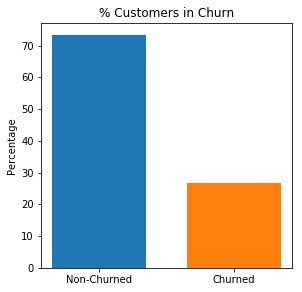

In [50]:
churn = """
    select churn, count(*) as cnt from cust_data group by churn
"""

C_df = sqldf(churn, locals())

objects = ['Non-Churned', 'Churned']
y_pos = np.arange(len(objects))
performance = C_df["cnt"]*100/(5163+1869)
color = ['C0', 'C1']
 
plt.figure(figsize=(4.5,4.5))
plt.bar(y_pos, performance, align='center', alpha=1, width=0.7, color = color)
plt.xticks(y_pos, objects)
plt.ylabel('Percentage')
plt.title('% Customers in Churn')

while True:
    display(C_df)
    break
    
plt.show()

### Churned customers by Gender

- Customer churn is almost similar with in Male and Female segments
- 30% of the customers churn in both the genders
- We could say that the gender is not impacting the churn

,gender,Churn,cnt
0,Female,0,2544
1,Female,1,939
2,Male,0,2619
3,Male,1,930


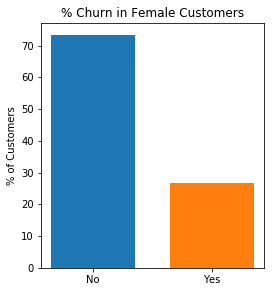

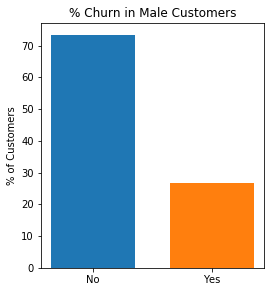

In [51]:
gender_churn = """
    select gender, churn, count(*) as cnt from cust_data group by gender, churn
"""

GC_df = sqldf(gender_churn, locals())

while True:
    display(GC_df)
    break
    
objects = ['No', 'Yes']
y_pos = np.arange(len(objects))
performance1 = GC_df[GC_df['gender'] == 'Female']["cnt"]*100/(2549+939)
color = ['C0','C1']
 
  
plt.figure(figsize=(4,4.5))
plt.bar(y_pos, performance, align='center', alpha=1, width=0.7, color = color)
plt.xticks(y_pos, objects)
plt.ylabel('% of Customers')
plt.title('% Churn in Female Customers')
plt.show()
 
objects = ['No', 'Yes'] #GC_df[GC_df['gender'] == 'Male']['Churn']
y_pos = np.arange(len(objects))
performance2 = GC_df[GC_df['gender'] == 'Male']["cnt"]*100/(2625+930)
color = ['C0','C1']
 
plt.figure(figsize=(4,4.5))
plt.bar(y_pos, performance, align='center', alpha=1, width=0.7, color = color)
plt.xticks(y_pos, objects)
plt.ylabel('% of Customers')
plt.title('% Churn in Male Customers')
plt.show()

### Churned customers by Senior citizen flag: 

More senior citizens churn out than non senior citizens

- 23% of customers in non senior citizen segment churn out
- Where as 41% of senior citizens churn out

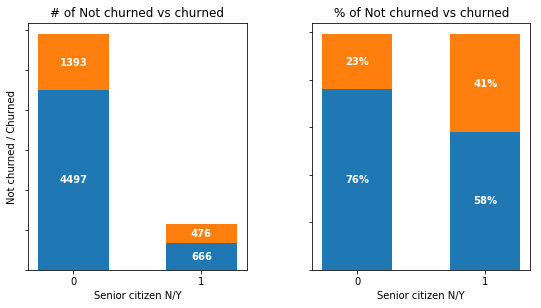

In [52]:


snr_ctzn_churn = """
    select
        SeniorCitizen,
        not_churned,
        churned,
        (not_churned*100/total_users) as not_churn_pctg,
        (churned*100/total_users) as churn_pctg
    from
    (
    select 
        SeniorCitizen, 
        sum(case when churn=0 then 1 else 0 end) as not_churned,
        sum(case when churn=1 then 1 else 0 end) as churned,
        sum(1) as total_users
    from cust_data 
    group by SeniorCitizen
    ) x   
"""

snr_ctzn_churn_df = sqldf(snr_ctzn_churn, locals())

#print(snr_ctzn_churn_df)

senior_ctz = snr_ctzn_churn_df.iloc[:,0]
not_churned = snr_ctzn_churn_df.iloc[:,1]
churned = snr_ctzn_churn_df.iloc[:,2]

indx = np.arange(len(snr_ctzn_churn_df))
plt.figure(figsize=(9,10))
plt.subplot(2,2,1)

graphNotChurned = plt.bar(x=indx, height=not_churned, width = 0.55)
graphChurned = plt.bar(x=indx, height=churned, width = 0.55, bottom=not_churned)

plt.xlabel('Senior citizen N/Y')
plt.ylabel('Not churned / Churned')


plt.xticks(indx,senior_ctz)
plt.title('# of Not churned vs churned')

for r1, r2 in zip(graphNotChurned, graphChurned):
    h1 = r1.get_height()
    h2 = r2.get_height()
    plt.text(r1.get_x() + r1.get_width() / 2., h1 / 2., "%d" % h1, ha="center", va="center", color="white", fontsize=10, fontweight="bold")
    plt.text(r2.get_x() + r2.get_width() / 2., h1 + h2 / 2., "%d" % h2, ha="center", va="center", color="white", fontsize=10, fontweight="bold")

# hiding the y-axis labels
frame1 = plt.gca()
frame1.axes.yaxis.set_ticklabels([])



############# Sub plot for percentage graphs #############

senior_ctz = snr_ctzn_churn_df.iloc[:,0]
not_churned_pct = snr_ctzn_churn_df.iloc[:,3]
churned_pct = snr_ctzn_churn_df.iloc[:,4]

indx_pct = np.arange(len(snr_ctzn_churn_df))
plt.subplot(2,2,2)

graphNotChurned_pct = plt.bar(x=indx_pct, height=not_churned_pct, width = 0.55)
graphChurned_pct = plt.bar(x=indx_pct, height=churned_pct, width = 0.55, bottom=not_churned_pct)

plt.xlabel('Senior citizen N/Y')
#plt.ylabel('Not churned / Churned')


plt.xticks(indx,senior_ctz)
plt.title('% of Not churned vs churned')

for r1, r2 in zip(graphNotChurned_pct, graphChurned_pct):
    h1 = r1.get_height()
    h2 = r2.get_height()
    plt.text(r1.get_x() + r1.get_width() / 2., h1 / 2., "%d" % h1+"%", ha="center", va="center", color="white", fontsize=10, fontweight="bold")
    plt.text(r2.get_x() + r2.get_width() / 2., h1 + h2 / 2., "%d" % h2+"%", ha="center", va="center", color="white", fontsize=10, fontweight="bold")

# hiding the y-axis labels
frame1 = plt.gca()
frame1.axes.yaxis.set_ticklabels([])

plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.3, hspace=None)

In [53]:
Tenure_churn = """
    select
        Tenure,
        not_churned,
        churned,
        (not_churned*100/total_users) as not_churn_pctg,
        (churned*100/total_users) as churn_pctg
    from
    (
        select 
            Tenure, 
            sum(case when churn=0 then 1 else 0 end) as not_churned,
            sum(case when churn=1 then 1 else 0 end) as churned,
            sum(1) as total_users
        from cust_data 
        group by Tenure
    ) x   
"""

Tenure_churn_df = sqldf(Tenure_churn, locals())

print(Tenure_churn_df.head())


   Tenure  not_churned  churned  not_churn_pctg  churn_pctg
0       1          233      380              38          61
1       2          115      123              48          51
2       3          106       94              53          47
3       4           93       83              52          47
4       5           69       64              51          48


### Churn by Tenure 

As the tenure of the customers increases with company, the percentage of customers churning out has been reducing significantly  

Initially with one or two months the percentage churning out has been as high as 45% but as numbers of months has increased the churn went down to as low as 3-4 %

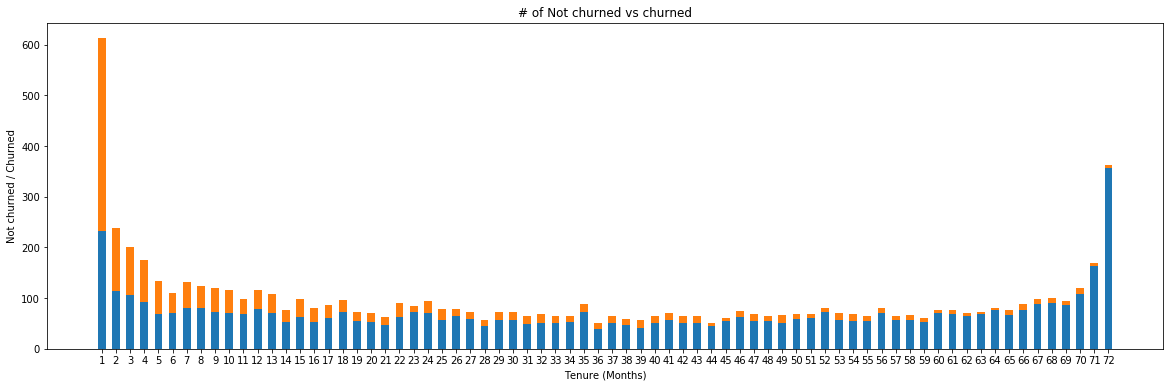

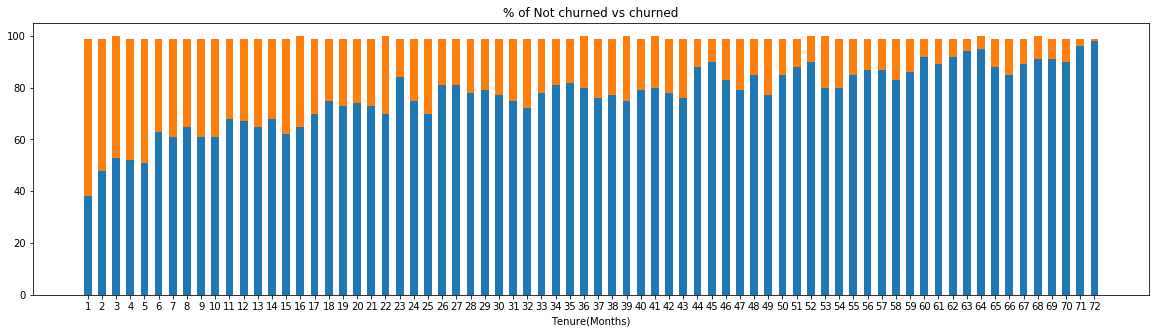

In [54]:
Tenure = Tenure_churn_df.iloc[:,0]
not_churned = Tenure_churn_df.iloc[:,1]
churned = Tenure_churn_df.iloc[:,2]

indx = np.arange(len(Tenure_churn_df))
plt.figure(figsize=(20,6))
#plt.subplot(2,2,1)

graphNotChurned = plt.bar(x=indx, height=not_churned, width = 0.55)
graphChurned = plt.bar(x=indx, height=churned, width = 0.55, bottom=not_churned)

plt.xlabel('Tenure (Months)')
plt.ylabel('Not churned / Churned')


plt.xticks(indx,Tenure)
plt.title('# of Not churned vs churned')

for r1, r2 in zip(graphNotChurned, graphChurned):
    h1 = r1.get_height()
    h2 = r2.get_height()
   # plt.text(r1.get_x() + r1.get_width() / 2., h1 / 2., "%d" % h1, ha="center", va="center", color="white", fontsize=10, fontweight="bold")
   # plt.text(r2.get_x() + r2.get_width() / 2., h1 + h2 / 2., "%d" % h2, ha="center", va="center", color="white", fontsize=10, fontweight="bold")

# hiding the y-axis labels
#frame1 = plt.gca()
#frame1.axes.yaxis.set_ticklabels([])


############# Sub plot for percentage graphs #############

Tenure = Tenure_churn_df.iloc[:,0]
not_churned_pct = Tenure_churn_df.iloc[:,3]
churned_pct = Tenure_churn_df.iloc[:,4]

indx_pct = np.arange(len(Tenure_churn_df))
plt.figure(figsize=(20,5))
#plt.subplot(2,2,2)

graphNotChurned_pct = plt.bar(x=indx_pct, height=not_churned_pct, width = 0.55)
graphChurned_pct = plt.bar(x=indx_pct, height=churned_pct, width = 0.55, bottom=not_churned_pct)

plt.xlabel('Tenure(Months)')
#plt.ylabel('Not churned / Churned')


plt.xticks(indx,Tenure)
plt.title('% of Not churned vs churned')

for r1, r2 in zip(graphNotChurned_pct, graphChurned_pct):
    h1 = r1.get_height()
    h2 = r2.get_height()
   # plt.text(r1.get_x() + r1.get_width() / 2., h1 / 2., "%d" % h1+"%", ha="center", va="center", color="white", fontsize=10, fontweight="bold")
   # plt.text(r2.get_x() + r2.get_width() / 2., h1 + h2 / 2., "%d" % h2+"%", ha="center", va="center", color="white", fontsize=10, fontweight="bold")



### Churn by Contract Type

- 42% of month on month customers churn out
- 11% churn out in customers with 1 year contract
- Only 2% churn out in customers with 2 year contract

Higher the contract term, lower is the churn rate


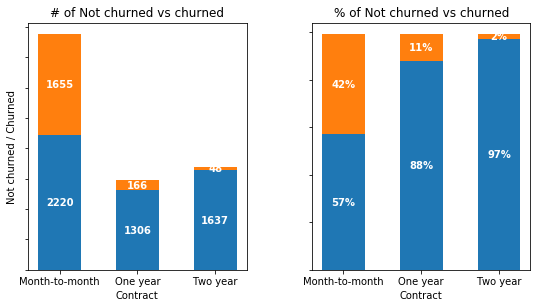

In [55]:
Contract_churn = """
    select
        Contract,
        not_churned,
        churned,
        (not_churned*100/total_users) as not_churn_pctg,
        (churned*100/total_users) as churn_pctg
    from
    (
    select 
        Contract, 
        sum(case when churn=0 then 1 else 0 end) as not_churned,
        sum(case when churn=1 then 1 else 0 end) as churned,
        sum(1) as total_users
    from cust_data 
    group by Contract
    ) x   
"""

Contract_churn_df = sqldf(Contract_churn, locals())

#print(Contract_churn_df)

contract = Contract_churn_df.iloc[:,0]
not_churned = Contract_churn_df.iloc[:,1]
churned = Contract_churn_df.iloc[:,2]

indx = np.arange(len(Contract_churn_df))
plt.figure(figsize=(9,10))
plt.subplot(2,2,1)

graphNotChurned = plt.bar(x=indx, height=not_churned, width = 0.55)
graphChurned = plt.bar(x=indx, height=churned, width = 0.55, bottom=not_churned)

plt.xlabel('Contract')
plt.ylabel('Not churned / Churned')


plt.xticks(indx,contract)
plt.title('# of Not churned vs churned')

for r1, r2 in zip(graphNotChurned, graphChurned):
    h1 = r1.get_height()
    h2 = r2.get_height()
    plt.text(r1.get_x() + r1.get_width() / 2., h1 / 2., "%d" % h1, ha="center", va="center", color="white", fontsize=10, fontweight="bold")
    plt.text(r2.get_x() + r2.get_width() / 2., h1 + h2 / 2., "%d" % h2, ha="center", va="center", color="white", fontsize=10, fontweight="bold")

# hiding the y-axis labels
frame1 = plt.gca()
frame1.axes.yaxis.set_ticklabels([])



############# Sub plot for percentage graphs #############

contract = Contract_churn_df.iloc[:,0]
not_churned_pct = Contract_churn_df.iloc[:,3]
churned_pct = Contract_churn_df.iloc[:,4]

indx_pct = np.arange(len(Contract_churn_df))
plt.subplot(2,2,2)

graphNotChurned_pct = plt.bar(x=indx_pct, height=not_churned_pct, width = 0.55)
graphChurned_pct = plt.bar(x=indx_pct, height=churned_pct, width = 0.55, bottom=not_churned_pct)

plt.xlabel('Contract')
#plt.ylabel('Not churned / Churned')


plt.xticks(indx,contract)
plt.title('% of Not churned vs churned')

for r1, r2 in zip(graphNotChurned_pct, graphChurned_pct):
    h1 = r1.get_height()
    h2 = r2.get_height()
    plt.text(r1.get_x() + r1.get_width() / 2., h1 / 2., "%d" % h1+"%", ha="center", va="center", color="white", fontsize=10, fontweight="bold")
    plt.text(r2.get_x() + r2.get_width() / 2., h1 + h2 / 2., "%d" % h2+"%", ha="center", va="center", color="white", fontsize=10, fontweight="bold")

# hiding the y-axis labels
frame1 = plt.gca()
frame1.axes.yaxis.set_ticklabels([])

plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.3, hspace=None)

###  Monthly Charges vs Total Charges 

This scatter plot gives us the relation between monthly charges and total charges

This shows it is a positively correlated as there will be no case of monthly charges > total charges and if one increases other would increase

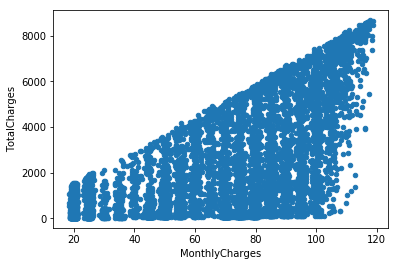

In [56]:
cust_data[['MonthlyCharges', 'TotalCharges']].plot.scatter(x = 'MonthlyCharges',
                                                              y='TotalCharges')

###  Monthly Charges vs Churn

We can clearly define that they are positively correlated 
 - As the churn is very high as the monthly amount increases.

 - The chun is lower when the bill amount monthly is lower

C:\Users\Jaikalyan\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.



Text(0.5, 1.0, 'Distribution of monthly charges by churn')

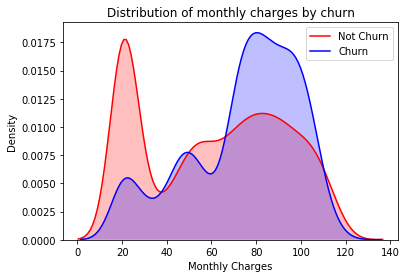

In [57]:
ax = sns.kdeplot(cust_data.MonthlyCharges[(cust_data["Churn"] == 0) ],
                color="Red", shade = True)
ax = sns.kdeplot(cust_data.MonthlyCharges[(cust_data["Churn"] == 1) ],
                ax =ax, color="Blue", shade= True)
ax.legend(["Not Churn","Churn"],loc='upper right')
ax.set_ylabel('Density')
ax.set_xlabel('Monthly Charges')
ax.set_title('Distribution of monthly charges by churn')

### Higher the Total charges - lower is the churn rate

This could be the case of causation rather than correlation. Users who pay more to the company have lower propensity to churn out

Text(0.5, 1.0, 'Distribution of total charges by churn')

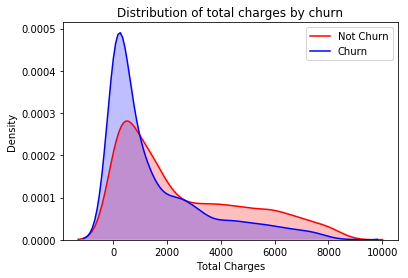

In [58]:
ax = sns.kdeplot(cust_data.TotalCharges[(cust_data["Churn"] == 0) ],
                color="Red", shade = True)
ax = sns.kdeplot(cust_data.TotalCharges[(cust_data["Churn"] == 1) ],
                ax =ax, color="Blue", shade= True)
ax.legend(["Not Churn","Churn"],loc='upper right')
ax.set_ylabel('Density')
ax.set_xlabel('Total Charges')
ax.set_title('Distribution of total charges by churn')

## Correlation 

- Correlation is usually defined as a measure of the linear relationship between two quantitative variables (e.g., height and weight). Often a slightly looser definition is used, whereby correlation simply means that there is some type of relationship between two variables.
- Correlation values could be positive or negetive ranging between [-1, +1], where +1 is highly correlated and -1 is least correlated.

## Correlation Matrix  

- A correlation matrix is a table showing correlation coefficients between variables. Each cell in the table shows the correlation between two variables. A correlation matrix is used as a way to summarize data, as an input into a more advanced analysis, and as a diagnostic for advanced analyses.
- As the gradient of the box is lighter, higher is the correlation
- Tenure and Total charges are highly corelated. This can be explained by customers with higher tenure paying more charges

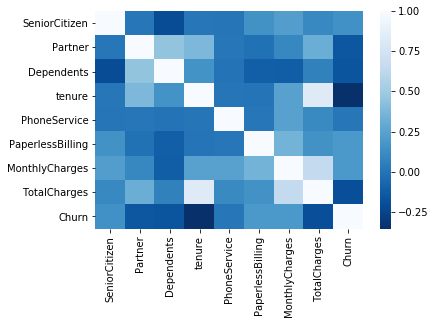

In [59]:
# calculate the correlation matrix
corr = cust_data.corr()

# plot the heatmap
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns,
           cmap = 'Blues_r')

### Manuplating data for application of logitic regression

Removing the customer id as that is a variable we have to find probability for in logistic regression.

In [60]:
df2 = cust_data

try:
    customer_id = df2['customerID'] # Store this as customer_id variable
    del df2['customerID'] # Don't need in ML DF
except:
    print("already removed customerID")

df2.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,1,0,1,0,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,1,Electronic check,29.85,29.85,0
1,Male,0,0,0,34,1,No,DSL,Yes,No,Yes,No,No,No,One year,0,Mailed check,56.95,1889.50,0
2,Male,0,0,0,2,1,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,1,Mailed check,53.85,108.15,1
3,Male,0,0,0,45,0,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,0,Bank transfer (automatic),42.30,1840.75,0
4,Female,0,0,0,2,1,No,Fiber optic,No,No,No,No,No,No,Month-to-month,1,Electronic check,70.70,151.65,1


## Creating Dummy Variables 

Dummies to convert the categorical variable to 0,1 values 

Since gender is a categorical variable with only two inputs we can convert it into 0,1 representing Female and Male respectively

As Logistic regression runs on the categorical variables, we need to convert the dependent variables into categorical variables using dummies function in python 

In [61]:
cust_data['gender'].replace(to_replace='Female', value=0, inplace=True)
cust_data['gender'].replace(to_replace='Male',  value=1, inplace=True)

cust_data_dummies = pd.get_dummies(df2)
cust_data_dummies.fillna(value=0, inplace=True)
cust_data_dummies.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,PaperlessBilling,MonthlyCharges,TotalCharges,Churn,...,StreamingMovies_No,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0,0,1,0,1,0,1,29.85,29.85,0,...,1,0,0,1,0,0,0,0,1,0
1,1,0,0,0,34,1,0,56.95,1889.50,0,...,1,0,0,0,1,0,0,0,0,1
2,1,0,0,0,2,1,1,53.85,108.15,1,...,1,0,0,1,0,0,0,0,0,1
3,1,0,0,0,45,0,0,42.30,1840.75,0,...,1,0,0,0,1,0,1,0,0,0
4,0,0,0,0,2,1,1,70.70,151.65,1,...,1,0,0,1,0,0,0,0,1,0


### Columns in Dummies Table after converting into 2 variable categorical columns

In [62]:
print(cust_data_dummies.columns)

Index(['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure',
       'PhoneService', 'PaperlessBilling', 'MonthlyCharges', 'TotalCharges',
       'Churn', 'MultipleLines_No', 'MultipleLines_No phone service',
       'MultipleLines_Yes', 'InternetService_DSL',
       'InternetService_Fiber optic', 'InternetService_No',
       'OnlineSecurity_No', 'OnlineSecurity_No internet service',
       'OnlineSecurity_Yes', 'OnlineBackup_No',
       'OnlineBackup_No internet service', 'OnlineBackup_Yes',
       'DeviceProtection_No', 'DeviceProtection_No internet service',
       'DeviceProtection_Yes', 'TechSupport_No',
       'TechSupport_No internet service', 'TechSupport_Yes', 'StreamingTV_No',
       'StreamingTV_No internet service', 'StreamingTV_Yes',
       'StreamingMovies_No', 'StreamingMovies_No internet service',
       'StreamingMovies_Yes', 'Contract_Month-to-month', 'Contract_One year',
       'Contract_Two year', 'PaymentMethod_Bank transfer (automatic)',
       'PaymentMetho

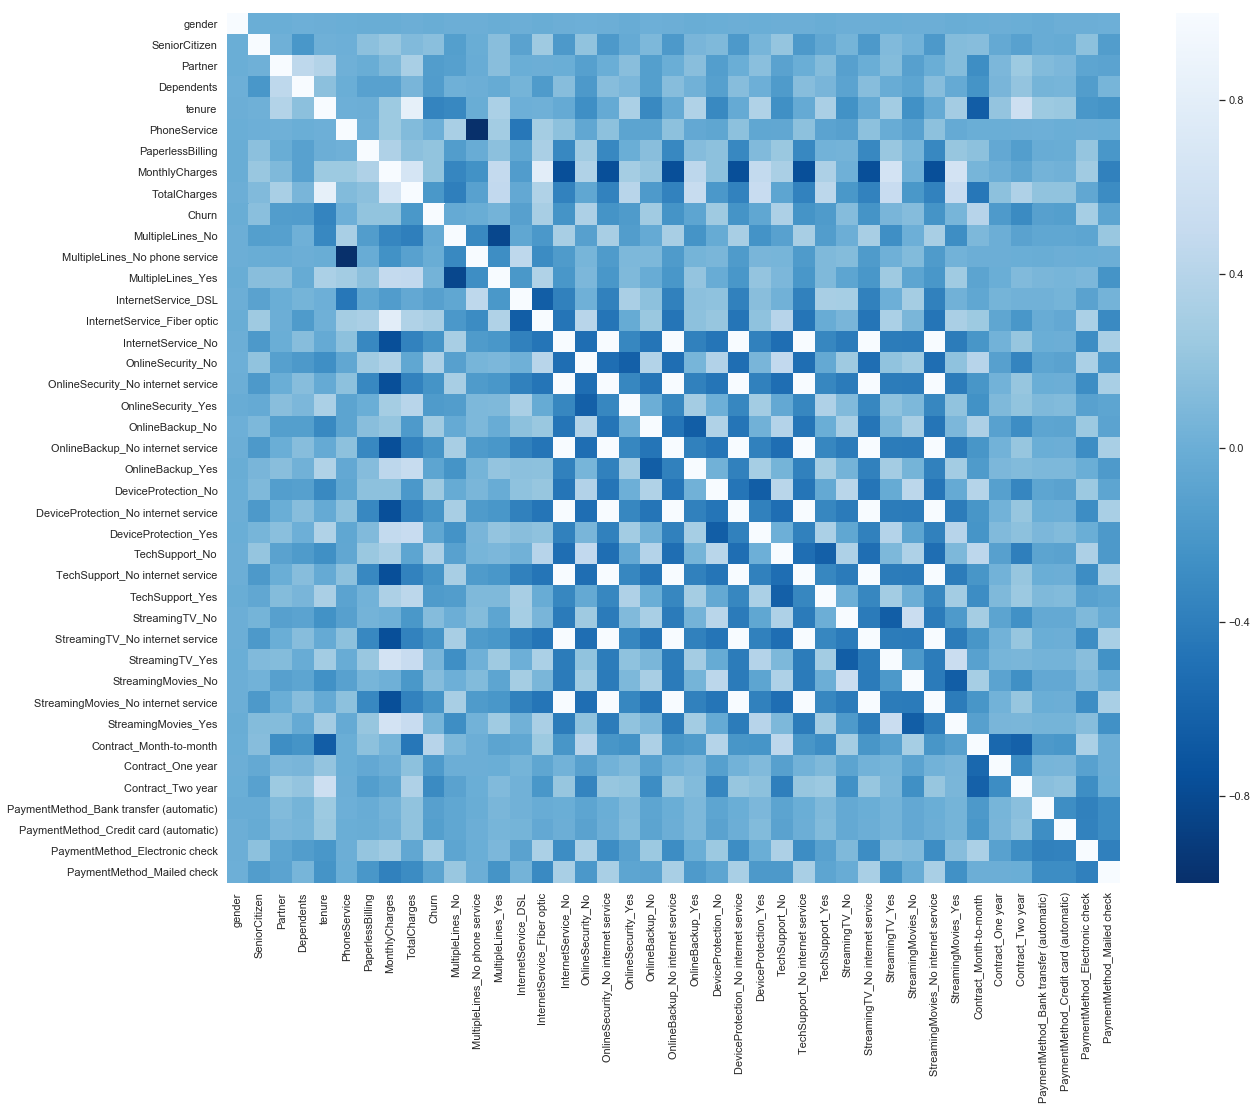

In [165]:
# calculate the correlation matrix
corr = cust_data_dummies.corr()

# plot the heatmap
sns.set(rc={'figure.figsize':(20,16)})
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns,
            cmap = 'Blues_r')

## Churn corelation with all other variables in data

<Figure size 360x360 with 0 Axes>

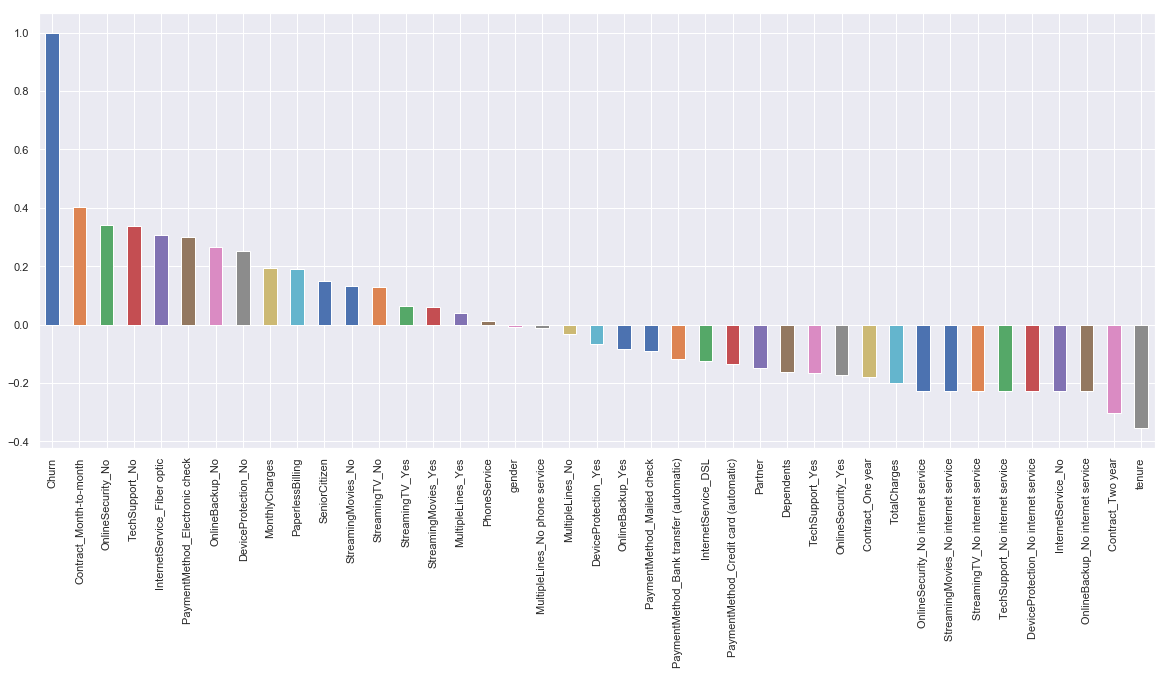

<Figure size 360x360 with 0 Axes>

In [128]:
plt.figure(figsize=(20,8))
cust_data_dummies.corr()['Churn'].sort_values(ascending = False).plot(kind='bar')
plt.figure(figsize=(5,5))

In [82]:
X = cust_data_dummies.loc[:, cust_data_dummies.columns != 'Churn']
y = cust_data_dummies.loc[:, cust_data_dummies.columns == 'Churn']

## Over-sampling using SMOTE
With our training data created, I’ll up-sample the churn using the SMOTE algorithm(Synthetic Minority Oversampling Technique). At a high level, SMOTE:

- Works by creating synthetic samples from the minor class (churn) instead of creating copies.
- Randomly choosing one of the k-nearest-neighbors and using it to create a similar, but randomly tweaked, new observations.


We are going to implement SMOTE in Python.

In [85]:
cust = SMOTE(random_state=0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
columns = X_train.columns
cust_data_X,cust_data_y=cust.fit_sample(X_train, y_train)
cust_data_X = pd.DataFrame(data=cust_data_X,columns=columns )
cust_data_y= pd.DataFrame(data=cust_data_y,columns=['y'])
# we can Check the numbers of our data
print("length of oversampled data is ",len(cust_data_X))
print("Number of churns in oversampled data",len(cust_data_y[cust_data_y['y']==0]))
print("Number of no churns",len(cust_data_y[cust_data_y['y']==1]))
print("Proportion of churn data in oversampled data is ",len(cust_data_y[cust_data_y['y']==0])/len(cust_data_X))
print("Proportion of no churn data in oversampled data is ",len(cust_data_y[cust_data_y['y']==1])/len(cust_data_X))

length of oversampled data is  7216
Number of churns in oversampled data 3608
Number of no churns 3608
Proportion of churn data in oversampled data is  0.5
Proportion of no churn data in oversampled data is  0.5


C:\Users\Jaikalyan\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Users\Jaikalyan\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



Now we have a perfect balanced data. 

I over-sampled only on the training data for no-churns which are less on the data, because by oversampling only on the training data, none of the information in the test data is being used to create synthetic observations.

## Recursive Feature Elimination

- Recursive Feature Elimination (RFE) is based on the idea to repeatedly construct a model and choose either the best or worst performing feature, setting the feature aside and then repeating the process with the rest of the features. 
- This process is applied until all features in the dataset are exhausted. The goal of RFE is to select features by recursively considering smaller and smaller sets of features.

In [86]:
cust_data_dummies_col= cust_data_dummies.columns.values.tolist()
y=['Churn']
X=[i for i in cust_data_dummies_col if i not in y]

logreg = LogisticRegression()
rfe = RFE(logreg, 35)
rfe = rfe.fit(cust_data_X, cust_data_y.values.ravel())

print(rfe.support_)
print(rfe.ranking_)

[ True  True  True  True  True False  True False False  True  True  True
  True  True  True  True  True  True  True  True  True False  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True False]
[1 1 1 1 1 5 1 4 6 1 1 1 1 1 1 1 1 1 1 1 1 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 2]


In [158]:
cols = ['SeniorCitizen', 'tenure', 'PaperlessBilling', 'MonthlyCharges', 'TotalCharges',
       'InternetService_Fiber optic', 'InternetService_No',
       'OnlineSecurity_No', 'OnlineBackup_No', 'DeviceProtection_No', 'TechSupport_No',
       'Contract_Month-to-month', 'Contract_One year',
       'Contract_Two year', 'PaymentMethod_Electronic check']

X=cust_data_X[cols]
y=cust_data_y['y']

# Logistic Regression

Logistic regression is a statistical method for predicting binary classes. The outcome or target variable is dichotomous in nature. Dichotomous means there are only two possible classes. For example, it can be used for cancer detection problems. It computes the probability of an event occurrence.
It is a special case of linear regression where the target variable is categorical in nature. It uses a log of odds as the dependent variable. Logistic Regression predicts the probability of occurrence of a binary event utilizing a logit function.
Linear Regression Equation:
                
                            Y = β0 + β1X1 + β2X2 + ……………… + βnXn
                                                 
Where, y is dependent variable and x1, x2 ... and Xn are explanatory variables.

Sigmoid Function:
                            
                            p = 1/(1+e^-y)
                      
Apply Sigmoid function on linear regression:

                            p = 1/(1+e^(-(β0 + β1X1 + β2X2 + ……………… + βnXn)))
                                                 
Properties of Logistic Regression:
The dependent variable in logistic regression follows Bernoulli Distribution.
Estimation is done through maximum likelihood.
No R Square, Model fitness is calculated through Concordance, KS-Statistics.


In [159]:
logit_model=sm.Logit(y,X)
result=logit_model.fit()

print(result.summary())

Optimization terminated successfully.
         Current function value: 0.469207
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                 7216
Model:                          Logit   Df Residuals:                     7201
Method:                           MLE   Df Model:                           14
Date:                Tue, 26 Mar 2019   Pseudo R-squ.:                  0.3231
Time:                        15:10:34   Log-Likelihood:                -3385.8
converged:                       True   LL-Null:                       -5001.8
                                        LLR p-value:                     0.000
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
SeniorCitizen                      0.4047      0.086      4.707     

### Eliminating the columns which doesnot have the significant values of p( which should be <0.05 for considering the variable to be significant)

Columns elimanated by condition on p are:
- MonthlyCharges
- DeviceProtection_No

In [160]:
cols = ['SeniorCitizen', 'tenure', 'PaperlessBilling', 'TotalCharges',
       'InternetService_Fiber optic', 'InternetService_No',
       'OnlineSecurity_No', 'OnlineBackup_No', 'TechSupport_No',
       'Contract_Month-to-month', 'Contract_One year',
       'Contract_Two year', 'PaymentMethod_Electronic check']

X=cust_data_X[cols]
y=cust_data_y['y']
logit_model=sm.Logit(y,X)
result=logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.469287
         Iterations 7
                                Results: Logit
Model:                   Logit                 Pseudo R-squared:      0.323    
Dependent Variable:      y                     AIC:                   6798.7542
Date:                    2019-03-26 15:11      BIC:                   6888.2469
No. Observations:        7216                  Log-Likelihood:        -3386.4  
Df Model:                12                    LL-Null:               -5001.8  
Df Residuals:            7203                  LLR p-value:           0.0000   
Converged:               1.0000                Scale:                 1.0000   
No. Iterations:          7.0000                                                
-------------------------------------------------------------------------------
                                Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
---------------------------------------------------

## Training Model 

Once the independent columns are descided. We need to use the train data for training the model to identify the churn customers using the columns identified above.

In [139]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

## Prediction using the test data

Once logreg has been trained using the train data, you apply the same model on X_test to predict the Y(churn probability)

In this case the prediction has been true upto 77% of the cases.

In [99]:
y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.77


## Confusion Matrix:

A confusion matrix is a table that is often used to describe the performance of a classification model (or "classifier") on a set of test data for which the true values are known. The confusion matrix itself is relatively simple to understand, but the related terminology can be confusing.

- true positives (TP): These are cases in which we predicted yes (they have the disease), and they do have the disease.
- true negatives (TN): We predicted no, and they don't have the disease.
- false positives (FP): We predicted yes, but they don't actually have the disease. (Also known as a "Type I error.")
- false negatives (FN): We predicted no, but they actually do have the disease. (Also known as a "Type II error.")


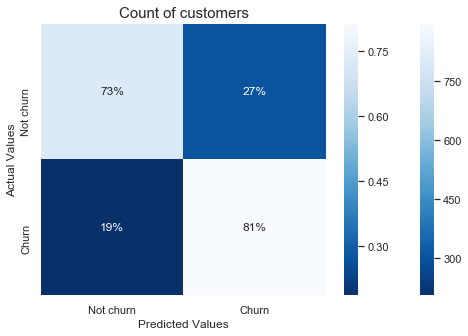

In [140]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_pred)
#print(cnfm)
plt.figure(figsize=(8,5))
sns.heatmap(confusion_matrix,
            xticklabels = ["Not churn","Churn"],
            yticklabels = ["Not churn","Churn"],
            cmap = 'Blues_r')
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
plt.title('Count of customers', size = 15);

confusion_matrix_normalised = [[773/(773+291), 291/(773+291)],
                               [206/(206+895), 895/(206+895)]]

hm = sns.heatmap(confusion_matrix_normalised,
            xticklabels = ["Not churn","Churn"],
            yticklabels = ["Not churn","Churn"],
            cmap = 'Blues_r', annot=True, fmt="0.00%")
hm.set(xlabel='Predicted Values', ylabel='Actual Values')
plt.title('Count of customers', size = 15);


## Precision, Recall, f1-Score

- The precision is intuitively the ability of the classifier to not label a sample as positive if it is negative.
    - The precision is the ratio tp / (tp + fp) where tp is the number of true positives and fp the number of false positives.
- The recall is intuitively the ability of the classifier to find all the positive samples.
    - The recall is the ratio tp / (tp + fn) where tp is the number of true positives and fn the number of false negatives. 


In [93]:

print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

          0       0.79      0.73      0.76      1064
          1       0.75      0.81      0.78      1101

avg / total       0.77      0.77      0.77      2165



## ROC Curve

An ROC curve is a graphical representation of the trade off between the false negative and false positive rates for every possible cut off.

Equivalently, the ROC curve is the representation of the tradeoffs between sensitivity (Sn) and specificity (Sp).


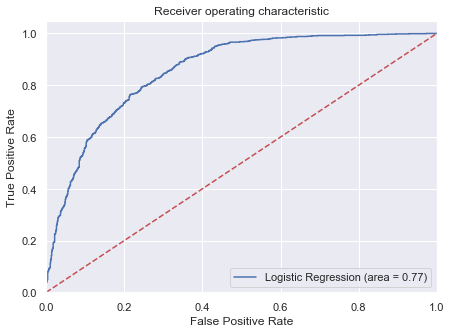

In [136]:

logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])
plt.figure(figsize=(7,5))
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

Sensitivity = True Positive Rate

Specificity = False Positive Rate

# Conclusions:

#### Downloaded the data
Data set has been downloaded from 

- https://www.kaggle.com/blastchar/telco-customer-churn

##### Data Description
The data set includes information about:

- Customers who left within the last month – the column is called Churn
- Services that each customer has signed up for – phone, multiple lines, internet, online security, online backup, device protection, tech support, and streaming TV and movies
- Customer account information – how long they’ve been a customer, contract, payment method, paperless billing, monthly charges, and total charges
- Demographic info about customers – gender, age range, and if they have partners and dependents

#### Defining the problem statement

Predicting customer churn, so the telecom company can develop customer retention programs to retain these customers thus preventing churn.

#### Cleaning Data: 
- removed rows with missing values
- removed duplicate rows
- Indentified and converted the column data types to their right data type which represents the nature of the metric

#### EDA
Identified Various variables effecting the churn 
- Customer churn is as high as 30% 
- Gender is one of the factor that is not effecting the customer churn as both genders have same percentage of churn(30 % same as total population).
- The Churn is dependent on age(Senior Citizen or not), as the churn is only 24% for non senior citizens and as high as 41% for senior citizens
- As the relation between the customer and company stays longer the churn is low 
    - The churn is drastically falling from 40% to 3-4% as the tenure of customer increases
    - the churn is also low for one and two year contract customers that month -on - month customers
- Monthly charges are positively related to churn as there is high number of customer churning with high monthly charges
- In case of total charges churn is not positively correlated as it is because of causation. 
- Monthly and total charges are positively correlated 

#### Logistoic Regression

- Designated the train and test data(30%)
- Trained the logistic model using Train data
- Applied the model on test data and predicted the chance of churn
- Designed the confusion matrix to understand the TP,TN,FP,FN and the case of TypeI and TypeII errors.
- Precsion and ROC curve area is 0.77

##### The value of 0.77 for the area under ROC curve implies that this model is a good model.

# Referrences:

    1.https://towardsdatascience.com/building-a-logistic-regression-in-python-step-by-step-becd4d56c9c8
    2.https://www.kaggle.com/bandiatindra/telecom-churn-prediction
    3.http://www.pmean.com/99/roc.html
    4.https://www.datacamp.com/community/tutorials/understanding-logistic-regression-python
    5.https://www.dataschool.io/simple-guide-to-confusion-matrix-terminology/
        